In [ ]:
!nvidia-smi

Fri Mar 12 15:59:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# EYE GAZE SHARED TASK

In [ ]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_error
import pickle
from pickle import dump
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from nltk import WordNetLemmatizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, sent_tokenize 
from sklearn.preprocessing import OneHotEncoder


enc = OneHotEncoder(sparse = False)
Lemmatizer = WordNetLemmatizer()
scaler = MinMaxScaler()
vectorizer = TfidfVectorizer(stop_words=None, token_pattern = r'(?u)\b\S+\b')

seed = 69
np.random.seed(seed)
torch.manual_seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
BATCH_SIZE = 4
TFIDF_ERROR = 0.1
MAX_LEN = 95

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.9MB 14.1MB/s 
     |████████████████████████████████| 890kB 53.6MB/s 
     |████████████████████████████████| 3.2MB 52.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=71756a7b4a449107916283178498b47fffd9ebf8038d82675ad0c03ce50b7991
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### IMPORT TRANSFORMERS

In [ ]:
#@title
#from transformers import BertTokenizer, BertForTokenClassification, BertModel
#from transformers import AlbertTokenizer, AlbertModel
#from transformers import ElectraForTokenClassification, ElectraTokenizer
from transformers import RobertaForTokenClassification, RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base", add_prefix_space = True)
base_model = RobertaForTokenClassification.from_pretrained("roberta-base")

#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#base_model = BertForTokenClassification.from_pretrained("bert-base-uncased")
#base_model = BertModel.from_pretrained("bert-base-uncased")

#tokenizer = ElectraTokenizer.from_pretrained("google/electra-small-discriminator")
#base_model = ElectraForTokenClassification.from_pretrained("google/electra-small-discriminator")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

### DOWNLOAD DATA

In [ ]:
#train_data_file_path = "/content/drive/My Drive/CMCL Shared Task/preprocessed_dataset.csv"
#test_data_file_path = "/content/drive/My Drive/CMCL Shared Task/preprocessed_test_dataset.csv"
train_data_file_path = "/content/drive/My Drive/CMCL Shared Task/training_data.csv"
test_data_file_path = "/content/drive/My Drive/CMCL Shared Task/test_data.txt"


#file_path = "/content/drive/MyDrive/datasets/EyeGazeSharedTask/trial_data.csv"

train_data = pd.read_csv(train_data_file_path)
test_data = pd.read_csv(test_data_file_path)

In [ ]:
print("Train Data Shape = ", train_data.shape)
print("Test Data Shape = ", test_data.shape)
df = train_data.copy()
test_df = test_data.copy()

df

Train Data Shape =  (15736, 8)
Test Data Shape =  (3554, 8)


,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,0,0,Carlucci,28.397566,4.642973,6.190631,10.343594,94.117647
1,0,1,was,12.981744,3.534385,5.263977,4.565348,76.470588
2,0,2,deputy,25.152130,5.809781,9.926357,9.145251,100.000000
3,0,3,defense,20.283976,5.261551,8.092455,8.359293,88.235294
4,0,4,secretary,17.849899,4.135982,4.507129,5.686066,88.235294
...,...,...,...,...,...,...,...,...
15731,799,4,and,11.494253,3.326575,6.183489,3.807691,72.222222
15732,799,5,patient,23.754789,5.230420,7.826157,8.412660,100.000000
15733,799,6,wife,18.390805,3.674811,8.611980,6.669187,77.777778
15734,799,7,of,14.559387,4.380448,11.890443,6.114758,77.777778


In [ ]:
test_df

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,800,0,It's,5.747126,1.384927,1.384927,1.783566,33.333333
1,800,1,the,14.942529,2.859205,4.398777,4.773360,66.666667
2,800,2,funniest,33.333333,3.312829,8.673838,10.175607,100.000000
3,800,3,American,36.781609,3.426235,9.340527,10.711708,100.000000
4,800,4,comedy,27.586207,3.694285,8.725386,8.660091,91.666667
...,...,...,...,...,...,...,...,...
3549,990,5,pursued,17.241379,4.412523,7.529468,5.185745,100.000000
3550,990,6,a,3.448276,1.030963,1.030963,1.030963,25.000000
3551,990,7,career,13.793103,3.113509,3.993264,3.515585,83.333333
3552,990,8,in,1.149425,0.254304,0.254304,0.254304,8.333333


In [ ]:
# FUNCTION TO REMOVE THE <EOS> TOKEN IN THE DATASET

def remove_eos(df, train = True):
  cnt = 1
  if not train:
    cnt = 801
  endword = []
  for i in range(df.shape[0]-1):
    if (df.loc[i+1, "sentence_id"] == cnt):
      df.loc[i, "word"] = df.loc[i, "word"][:-5]   # Remove <EOS> for the last word of each sentence.
      cnt += 1
      endword.append(1)
    else:
      endword.append(-1) 
  s = df.loc[df.shape[0] - 1, "word"]              # Remove <EOS> for last element separately
  df.loc[df.shape[0] - 1, "word"] = s[:-6] 
  endword.append(1)
  df["endword"] = endword
  return df

In [ ]:
# FUNCTION TO CALCULATE NO OF TOKENS CREATED BY TOKENIZER PER WORD
# ADDS THE DATA IN A NEW COLUMN

def add_token_per_words(df):
  n_tokens_per_word = []
  cdf = 0
  cf_n_token_per_word = []
  for i, word in enumerate(df.word):
    n_tokens_per_word.append(len(tokenizer.encode(word)) - 2)
    if (i > 0) and (df.loc[i-1, "sentence_id"] != df.loc[i, "sentence_id"]):
      cdf = 0
    cdf += len(tokenizer.encode(word)) - 2
    cf_n_token_per_word.append(cdf)
  df["n_tokens"] = n_tokens_per_word
  df["cf_n_tokens"] = cf_n_token_per_word
  return df

In [ ]:
#@title
# FUNCTION TO CALCULATE THE NUMBER OF CHARACTERS PER WORD
# ADDS THE DATA IN A NEW COLUMN

def char_per_word(df):
  n_chars = []
  for word in df.word:
    n_chars.append(len(str(word)))
  df["n_chars"] = n_chars
  return df

In [ ]:
#@title
# FUNCTION TO CALCULATE THE DIFFERENCE BETWEEN NUMBER OF CHARACTERS IN WORD AND LEMMATIZED WORD
# ADDS AS A NEW COLUMN

def char_per_lemmatized_word(df):
  n_chars = []
  for word in df.word:
    n_chars.append(len(str(word)) - len(Lemmatizer.lemmatize(word)))
  df["n_char_lemmatized"] = n_chars
  return df

In [ ]:
#@title
import nltk
nltk.download("stopwords")
nltk.download("wordnet")

stopwords = nltk.corpus.stopwords
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#@title
# FUNCTION TO ASSERT WHETHER A WORD IS STOPWORD  OR NOT
# ADDS THE DATA IN A NEW COLUMN

def add_stopword_check(df):
  if_stopword = []
  for word in df.word:
    if word in stop_words:
      if_stopword.append(1)
    else:
      if_stopword.append(-1)

  df["stopword"] = if_stopword
  return df

In [ ]:
#@title
# FUNCTION TO DEFINE WHETHER IT IS A NUMBER OR NOT
# ADDS THE DATA AS A NEW COLUMN

def add_number_check(df):
  if_number = []
  for word in df.word:
    if_number.append(1 if word.isdigit() else -1)

  df["number"] = if_number
  return df

In [ ]:
# FUNCTION TO CALCULATE THE TFIDF OF THE TRAINING DATASET
# ADDS THE DATA IN A NEW COLUMN
# ALSO RETURNS A LIST OF THE SENTENCES

bad_words = []
punc = ",.;!"

def remove_punc(word):
  table = str.maketrans('', '', punc)
  return word.translate(table)

def calc_tfidf(df, train=True):
  start_pos = 0
  if not train:
    start_pos = 800
  n = np.array(df["sentence_id"])[-1]
  sentences = []
  tf_idfs = []
  MAX_LEN = 0
  for i in range(start_pos, n+1):   
    temp_df = df[df.sentence_id == i]
    sentence = (' ').join(np.array(temp_df.word))
    sentences.append(sentence)
    MAX_LEN = max(MAX_LEN, len(sentence.split()))
  print(sentences[:3])
  if train:
    tf_idf = vectorizer.fit_transform(sentences)
  else:
    tf_idf = vectorizer.transform(sentences)

  for i, word in enumerate(df.word):
    try:
      tf_idfs.append(tf_idf.toarray()[df["sentence_id"][i]- start_pos][vectorizer.get_feature_names().index(remove_punc(word.lower()))])
    except:
      bad_words.append(word)
      if word in ["a", "A", "I"]:
        tf_idfs.append(0.05)
      else:
        tf_idfs.append(TFIDF_ERROR)
  df["tf_idf"] = tf_idfs

  return sentences, df, bad_words

In [ ]:
#@title
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

convert_dict = {"NNS":"NN",
                "PRP":"DT",
                "NN":"NN",
                "NNP":"NNP",
                "DT":"DT",
                "VB":"VB",
                "JJ":"JJ",
                "CD":"CD"}

def pos_tag_func(df, train=True):
  tags = []
  word_tag_tuple = nltk.pos_tag(df["word"])
  for word, tag in word_tag_tuple:
    if tag in convert_dict.keys():
      tags.append(convert_dict[tag]) 
    else:
      tags.append("unk")
  df["tags"] = tags
  
  if train:
    tag_transform = pd.DataFrame(enc.fit_transform(np.array(df.tags).reshape(-1, 1)))
  else:
    tag_transform = pd.DataFrame(enc.transform(np.array(df.tags).reshape(-1, 1)))
  df = pd.concat((df, tag_transform), axis = 1)
  return df

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# FUNCTION TO PERFORM ALL PREPROCESSING STEPS
def preprocess(df, train = True):
  return calc_tfidf(pos_tag_func(add_number_check(add_stopword_check(char_per_lemmatized_word(char_per_word(add_token_per_words(remove_eos(df, train)))))), train), train)


In [ ]:
sentences, df, bad_words = preprocess(df)
test_sentences, test_df, test_bad_words = preprocess(test_df, False)
df

['Carlucci was deputy defense secretary from 1981 until 1986, national security advisor from 1986 until 1987, and defense secretary in 1987, following the resignation of Weinberger, his nomination by President Ronald Reagan and his confirmation in the Senate by a vote of 91 to 1.', 'All members of the Bouvier family (except, of course, Marge) smoke heavily and have gruff voices and sarcastic, snarky demeanours.', "Genuinely touching because it's realistic about all kinds of love."]
["It's the funniest American comedy since Graffiti Bridge.", 'For a time in the summer of 1823, his expedition was joined by Italian explorer Giacomo Beltrami.', 'This method almost never fails him, and it works superbly here.']


,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,endword,n_tokens,cf_n_tokens,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,tf_idf
0,0,0,Carlucci,28.397566,4.642973,6.190631,10.343594,94.117647,-1,3,3,8,0,-1,-1,NNP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.176250
1,0,1,was,12.981744,3.534385,5.263977,4.565348,76.470588,-1,1,4,3,1,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.059555
2,0,2,deputy,25.152130,5.809781,9.926357,9.145251,100.000000,-1,1,5,6,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.176250
3,0,3,defense,20.283976,5.261551,8.092455,8.359293,88.235294,-1,1,6,7,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.306310
4,0,4,secretary,17.849899,4.135982,4.507129,5.686066,88.235294,-1,1,7,9,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.271369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15731,799,4,and,11.494253,3.326575,6.183489,3.807691,72.222222,-1,1,7,3,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.125612
15732,799,5,patient,23.754789,5.230420,7.826157,8.412660,100.000000,-1,1,8,7,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.482584
15733,799,6,wife,18.390805,3.674811,8.611980,6.669187,77.777778,-1,1,9,4,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.364676
15734,799,7,of,14.559387,4.380448,11.890443,6.114758,77.777778,-1,1,10,2,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.131243


In [ ]:
len(bad_words), len(test_bad_words)

(1187, 1187)

In [ ]:
bad_words[:5]

['(except,', 'Marge)', '...', '(May', '-']

In [ ]:
test_df

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,endword,n_tokens,cf_n_tokens,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,tf_idf
0,800,0,It's,5.747126,1.384927,1.384927,1.783566,33.333333,-1,2,2,4,0,-1,-1,NNP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.301302
1,800,1,the,14.942529,2.859205,4.398777,4.773360,66.666667,-1,1,3,3,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.106428
2,800,2,funniest,33.333333,3.312829,8.673838,10.175607,100.000000,-1,2,5,8,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.506531
3,800,3,American,36.781609,3.426235,9.340527,10.711708,100.000000,-1,1,6,8,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.297161
4,800,4,comedy,27.586207,3.694285,8.725386,8.660091,91.666667,-1,1,7,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.351511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3549,990,5,pursued,17.241379,4.412523,7.529468,5.185745,100.000000,-1,1,7,7,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.100000
3550,990,6,a,3.448276,1.030963,1.030963,1.030963,25.000000,-1,1,8,1,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.135377
3551,990,7,career,13.793103,3.113509,3.993264,3.515585,83.333333,-1,1,9,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.419793
3552,990,8,in,1.149425,0.254304,0.254304,0.254304,8.333333,-1,1,10,2,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.144474


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
training = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/training_data.csv")
keys = df.keys()[3:8]

b = scaler.fit_transform(df.loc[:, keys])     # Min Max scaling
b = pd.DataFrame(b, columns = keys)            
df.update(b)                                  # Updating values to Min max scaled values
c = scaler.transform(test_df.loc[:, keys])
c = pd.DataFrame(c, columns = keys)
test_df.update(c)

In [ ]:
df

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,endword,n_tokens,cf_n_tokens,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,tf_idf
0,0,0,Carlucci,0.283976,0.379324,0.061906,0.261297,0.941176,-1,3,3,8,0,-1,-1,NNP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.176250
1,0,1,was,0.129817,0.288754,0.052640,0.115329,0.764706,-1,1,4,3,1,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.059555
2,0,2,deputy,0.251521,0.474651,0.099264,0.231025,1.000000,-1,1,5,6,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.176250
3,0,3,defense,0.202840,0.429861,0.080925,0.211170,0.882353,-1,1,6,7,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.306310
4,0,4,secretary,0.178499,0.337904,0.045071,0.143640,0.882353,-1,1,7,9,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.271369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15731,799,4,and,0.114943,0.271777,0.061835,0.096189,0.722222,-1,1,7,3,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.125612
15732,799,5,patient,0.237548,0.427318,0.078262,0.212518,1.000000,-1,1,8,7,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.482584
15733,799,6,wife,0.183908,0.300227,0.086120,0.168475,0.777778,-1,1,9,4,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.364676
15734,799,7,of,0.145594,0.357877,0.118904,0.154469,0.777778,-1,1,10,2,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.131243


In [ ]:
test_df

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,endword,n_tokens,cf_n_tokens,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,tf_idf
0,800,0,It's,0.057471,0.113147,0.013849,0.045056,0.333333,-1,2,2,4,0,-1,-1,NNP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.301302
1,800,1,the,0.149425,0.233593,0.043988,0.120583,0.666667,-1,1,3,3,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.106428
2,800,2,funniest,0.333333,0.270653,0.086738,0.257054,1.000000,-1,2,5,8,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.506531
3,800,3,American,0.367816,0.279919,0.093405,0.270596,1.000000,-1,1,6,8,0,-1,-1,JJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.297161
4,800,4,comedy,0.275862,0.301818,0.087254,0.218769,0.916667,-1,1,7,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.351511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3549,990,5,pursued,0.172414,0.360497,0.075295,0.131001,1.000000,-1,1,7,7,0,-1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.100000
3550,990,6,a,0.034483,0.084228,0.010310,0.026044,0.250000,-1,1,8,1,0,1,-1,DT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.135377
3551,990,7,career,0.137931,0.254369,0.039933,0.088810,0.833333,-1,1,9,6,0,-1,-1,NN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.419793
3552,990,8,in,0.011494,0.020776,0.002543,0.006424,0.083333,-1,1,10,2,0,1,-1,unk,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.144474


In [ ]:
'''
df_data = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/Sentences_maxlen.csv")
sentences = list(df_data["sentences"])
MAX_LEN = df_data["max_len"][0]

test_df_data = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/Test_Sentences_maxlen.csv")
test_sentences = list(test_df_data["sentences"])
test_MAX_LEN = test_df_data["max_len"][0]
'''

'\ndf_data = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/Sentences_maxlen.csv")\nsentences = list(df_data["sentences"])\nMAX_LEN = df_data["max_len"][0]\n\ntest_df_data = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/Test_Sentences_maxlen.csv")\ntest_sentences = list(test_df_data["sentences"])\ntest_MAX_LEN = test_df_data["max_len"][0]\n'

In [ ]:
test_sentences[0]

"It's the funniest American comedy since Graffiti Bridge."

In [ ]:
#standardize_target(df)

#dump(std_scaler, open("/content/drive/My Drive/CMCL Shared Task/StandardScaler.pkl", "wb"))

In [ ]:
#df.to_csv("/content/drive/My Drive/CMCL Shared Task/preprocessed_dataset_NEWWW.csv", index = False)
#test_df.to_csv("/content/drive/My Drive/CMCL Shared Task/preprocessed_test_dataset_NEWWW.csv", index = False)

In [ ]:
'''
sent_len_dict = {'sentences':sentences,
                 "max_len":MAX_LEN}
test_sent_len_dict = {'sentences':test_sentences,
                 "max_len":test_MAX_LEN}

pd.DataFrame(sent_len_dict).to_csv("/content/drive/My Drive/CMCL Shared Task/Sentences_maxlen.csv")
pd.DataFrame(test_sent_len_dict).to_csv("/content/drive/My Drive/CMCL Shared Task/Test_Sentences_maxlen.csv")

dump(std_scaler, open("/content/drive/My Drive/CMCL Shared Task/StandardScaler.pkl", "wb"))
dump(vectorizer, open("/content/drive/My Drive/CMCL Shared Task/TfIdfVectorizer.pkl", "wb"))
dump(enc, open("/content/drive/My Drive/CMCL Shared Task/OneHotEncoder.pkl", "wb"))
'''

'\nsent_len_dict = {\'sentences\':sentences,\n                 "max_len":MAX_LEN}\ntest_sent_len_dict = {\'sentences\':test_sentences,\n                 "max_len":test_MAX_LEN}\n\npd.DataFrame(sent_len_dict).to_csv("/content/drive/My Drive/CMCL Shared Task/Sentences_maxlen.csv")\npd.DataFrame(test_sent_len_dict).to_csv("/content/drive/My Drive/CMCL Shared Task/Test_Sentences_maxlen.csv")\n\ndump(std_scaler, open("/content/drive/My Drive/CMCL Shared Task/StandardScaler.pkl", "wb"))\ndump(vectorizer, open("/content/drive/My Drive/CMCL Shared Task/TfIdfVectorizer.pkl", "wb"))\ndump(enc, open("/content/drive/My Drive/CMCL Shared Task/OneHotEncoder.pkl", "wb"))\n'

### FORM TARGETS

In [ ]:
# FUNCTION TO FORM TARGETS AND OTHER FEATURES IN SEPARATE DATA STRUCTURES

def form_targets(sentences, df, MAX_LEN, train = True):
  start_pos = 800
  if train:
    start_pos = 0
  n = np.array(df["sentence_id"])[-1] - start_pos
  targets = []
  tags = []
  cdfs = []
  features = {"n_chars" : [],
              "stopword" : [],
              "number" : [],
              "endword":[],
              "n_char_lemmatized" : [],
              "tf_idf" : [],
              }

  for i in range(n+1):
    feature = {}
    actual_features = {}
    temp_df = df[df.sentence_id == (i+start_pos)]
    
    cdf = [0 for i in range(MAX_LEN - len(sentences[i].split()))]
    actual_cdf = list(np.array(temp_df.loc[:, "cf_n_tokens"]))
    actual_cdf += cdf

    target = [0 for i in range(MAX_LEN - len(sentences[i].split()))]
    actual_targets = list(np.array(temp_df.loc[:, "TRT"]))
    actual_targets += target

    for key in features.keys():
      feature[key] = [0 for j in range(MAX_LEN - len(sentences[i].split()))]
      actual_features[key] = list(np.array(temp_df.loc[:, key]))
      actual_features[key] += feature[key]

    tag = [[0 for j in range(6)] for k in range(MAX_LEN - len(sentences[i].split()))]
    actual_tag = [list(x) for x in np.array(temp_df.iloc[:, -8:-2])]
    actual_tag += tag

    for key in features.keys():
      features[key].append(actual_features[key]) 
    
    targets.append(actual_targets) 
    tags.append(actual_tag)
    cdfs.append(actual_cdf)

  return targets, features, tags, cdfs


In [ ]:
targets, features, tags, cdfs = form_targets(sentences, df, MAX_LEN)
test_targets, test_features, test_tags, test_cdfs = form_targets(test_sentences, test_df, MAX_LEN, False)

In [ ]:
np.array(tags).shape, np.array(test_tags).shape

((800, 95, 6), (191, 95, 6))

In [ ]:
np.array(targets).shape, np.array(test_targets).shape

((800, 95), (191, 95))

In [ ]:
#@title
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=20, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### FORMING CLASS OF DATA

In [ ]:
# Class for the data
# Contains 4 keys -> Sentences, targets, input_ids(for BERT), attention_mask(for BERT) 

class EyeGaze_dataset(Dataset):

  def __init__(self, sentences, targets = None, cdfs = None, features = None, tags = None, tokenizer = None, train = True):
    self.sentences = sentences               # List of Sentences
    self.targets = targets                   # List of Padded Targets
    self.tokenizer = tokenizer               # Tokenizer to be used (BERT)
    self.cdfs = cdfs                         # Cumulative Frequency Function
    self.features = features
    self.tags = tags
    self.train = train
    
  def __len__(self):
    return len(self.sentences)               # No of Examples = 100

  def __getitem__(self, index):
    sentence = str(self.sentences[index])        # Get the review at the particular index
    target = self.targets[index]                    # Get the target label at the particular index
    cdf = self.cdfs[index]
    feature = {}
    
    for key in features.keys():
      feature[key] = features[key][index]
    tag = tags[index]
    encoding = self.tokenizer.encode_plus(   # Encoder encoding the particular review
        sentence,
        return_attention_mask = True,
        padding = "max_length",
        max_length = MAX_LEN,
        return_tensors = "pt"
    )
    # The class simply returns a dictionary of the following
    return_dict = {"target":torch.tensor(target, dtype = torch.float32),
                    "input_ids":encoding["input_ids"].flatten(),
                    "attention_mask":encoding["attention_mask"].flatten(),
                    "cdf": torch.tensor(cdf, dtype = torch.int16),
                    "tag":torch.tensor(tag, dtype = torch.float32)}
    '''
    else:
      return_dict = {"input_ids":encoding["input_ids"].flatten(),
                    "attention_mask":encoding["attention_mask"].flatten(),
                    "cdf": torch.tensor(cdf, dtype = torch.int16),
                    "tag":torch.tensor(tag, dtype = torch.float32)}
    '''
    for key in features.keys():
      return_dict[key] = torch.tensor(feature[key], dtype = torch.float32)
    

    return return_dict

In [ ]:
# Forms the DataLoaders with test_size = 0.2
# Each DataLoader has the Class dataset as their elements
def create_data_loader(sentences, targets, cdfs, features, tags, tokenizer, batch_size, train = True):
  data = EyeGaze_dataset(sentences, targets, cdfs, features, tags, tokenizer, train)
  
  if train:
    train, val = train_test_split(data, test_size = 0.2, shuffle = True, random_state = seed)
    train_data_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
    val_data_loader = DataLoader(val, batch_size = batch_size, shuffle = False)
    return train_data_loader, val_data_loader
  test_data_loader = DataLoader(data, batch_size = batch_size, shuffle = False)
  return test_data_loader
  

In [ ]:
BATCH_SIZE = 4
train_data_loader, val_data_loader = create_data_loader(sentences, targets, cdfs, features, tags, tokenizer, BATCH_SIZE)
test_data_loader = create_data_loader(test_sentences, test_targets, test_cdfs, test_features, test_tags, tokenizer, BATCH_SIZE, False)

In [ ]:
temp = next(iter(train_data_loader))
print(temp.keys())
keys = ['target', 'input_ids', 'attention_mask',  'n_chars', 'n_char_lemmatized', 'cdf', 'stopword', 'number', 'tf_idf', "tag"]
for key in keys:
  print(temp[key].size())
temp = next(iter(test_data_loader))
for key in keys:
  print(temp[key].size())

dict_keys(['target', 'input_ids', 'attention_mask', 'cdf', 'tag', 'n_chars', 'stopword', 'number', 'endword', 'n_char_lemmatized', 'tf_idf'])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95, 6])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95])
torch.Size([4, 95, 6])


In [ ]:
temp["cdf"][1], temp["target"][1]

(tensor([ 1,  2,  3,  4,  5,  6,  7, 10, 11, 12, 13, 14, 15, 16, 17, 20, 24,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0], dtype=torch.int16),
 tensor([0.0733, 0.0613, 0.1133, 0.0505, 0.0618, 0.1150, 0.0390, 0.3142, 0.0485,
         0.1594, 0.0706, 0.1578, 0.0469, 0.1167, 0.1605, 0.2534, 0.2951, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

In [ ]:
base_model.config.output_hidden_states = True

In [ ]:
class LanguageHeadLayer(torch.nn.Module):
  def __init__(self):
    super(LanguageHeadLayer, self).__init__()
    self.mid = torch.nn.Linear(in_features = base_model.config.hidden_size, out_features = 128)
    self.out = torch.nn.Linear(in_features = 128, out_features = 256)
    self.act1 = torch.nn.ReLU()
    self.act2 = torch.nn.GELU()
    self.drop = torch.nn.Dropout(p = 0.3)

  def forward(self, output):
    output = self.mid(output)
    output = self.act2(output)
    output = self.drop(output)
    output = self.out(output)

    return output
    
class ExtraFeatureModel(torch.nn.Module):
  def __init__(self):
    super(ExtraFeatureModel, self).__init__()
    self.inp = torch.nn.Linear(in_features = 12, out_features = 256)
    self.transformerlayer = torch.nn.TransformerEncoderLayer(d_model = 256, nhead = 8, dim_feedforward = 256, dropout = 0.2, activation = "relu")
    self.transformer = torch.nn.TransformerEncoder(self.transformerlayer, num_layers = 2)
    self.act1 = torch.nn.GELU()
    self.act2 = torch.nn.ReLU()

  def forward(self, features):
    output = self.inp(features)
    output = self.act1(output)
    output = self.transformerlayer(output)
    output = torch.squeeze(output, dim = 0)

    return output

In [ ]:
class EyeGazeClassifier(torch.nn.Module):
  def __init__(self):
    super(EyeGazeClassifier, self).__init__()
    self.base_model = base_model
    self.languageheadlayer = LanguageHeadLayer()
    self.feature_model = ExtraFeatureModel()
    self.out = torch.nn.Linear(in_features = 256, out_features = 1)
    self.act_out = torch.nn.Sigmoid()

  def map_predictions(self, outputs, attention_masks, cdfs):
    for i in range(outputs.size()[0]):    
      output = outputs[i]
      attention_mask = attention_masks[i]
      cdf = cdfs[i]

      attention_mask = torch.unsqueeze(attention_mask, dim = 1)

      output = output*attention_mask

      pred_tensor = torch.unsqueeze(torch.mean(output[1:cdf[0]+1], dim = 0), dim = 0)

      for j in range(0, len(cdf)-1):
        if (cdf[j+1] != 0):
          y = torch.unsqueeze(torch.mean(output[cdf[j]+1:cdf[j+1]+1], dim = 0), dim = 0)
          pred_tensor = torch.cat((pred_tensor, y), dim = 0)

      pred_pad = torch.tensor([[0 for a in range(base_model.config.hidden_size)] for k in range(MAX_LEN - pred_tensor.size()[0])], dtype = torch.float32).to(device)
      pred_tensor = torch.cat((pred_tensor, pred_pad), dim = 0)
      if i==0:
        pred_tensors = torch.unsqueeze(pred_tensor, dim = 0)
      else:
        pred_tensors = torch.cat((pred_tensors, torch.unsqueeze(pred_tensor, dim = 0)), dim = 0)

    return pred_tensors

  def forward(self, input_ids, attention_mask, cdf, extra_features):
    lang_output = self.base_model(input_ids = input_ids, attention_mask = attention_mask)
    lang_output = self.map_predictions(lang_output["hidden_states"][-1], attention_mask, cdf)
    lang_output = self.languageheadlayer(lang_output)
    feature_output = self.feature_model(extra_features)
    output = (lang_output+feature_output)/2
    output = self.out(output)
    output = self.act_out(output)
    
    return output


In [ ]:
del model

In [ ]:
model = EyeGazeClassifier()
model = model.to(device)

### TRAINING

In [ ]:
EPOCHS = 70
from transformers import AdamW, get_linear_schedule_with_warmup

#opt_params = [{"params": model.languageheadlayer.parameters()},
#             {"params": model.feature_model.parameters()},
#              {"params": model.out.parameters()}]

#partial_optimizer = AdamW(opt_params, lr=2e-7, betas = (0.92, 0.998), correct_bias=False)
total_optimizer = AdamW(model.parameters(), lr = 3e-5, betas = (0.91, 0.998), weight_decay = 0, correct_bias = False)

total_steps = len(train_data_loader) * EPOCHS

#partial_scheduler = get_linear_schedule_with_warmup(
#  partial_optimizer,
#  num_warmup_steps=6,
#  num_training_steps=total_steps
#)

total_scheduler = get_linear_schedule_with_warmup(
  total_optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.L1Loss(reduction = "mean").to(device)  # reduction = "mean" can be used

In [ ]:
#@title
def target_initialise():
  targets = {}
  outputs = {}

  targets["r20"] = torch.tensor([], dtype = torch.float32)
  targets["r21"] = torch.tensor([], dtype = torch.float32)
  targets["r22"] = torch.tensor([], dtype = torch.float32)
  targets["r23"] = torch.tensor([], dtype = torch.float32)
  targets["r24"] = torch.tensor([], dtype = torch.float32)

  outputs["pred_r20"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r21"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r22"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r23"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r24"] = torch.tensor([], dtype = torch.float32)
  
  return targets, outputs

In [ ]:
#@title
def store_targets(targets, target):
  #targets["r20"] = torch.cat([targets["r20"], target[0,:,0].detach().cpu()], dim = 0)
  #targets["r21"] = torch.cat([targets["r21"], target[0,:,1].detach().cpu()], dim = 0)
  targets["r22"] = torch.cat([targets["r22"], target[:,:].detach().cpu()], dim = 0)
  #targets["r23"] = torch.cat([targets["r23"], target[0,:,3].detach().cpu()], dim = 0)
  #targets["r24"] = torch.cat([targets["r24"], target[0,:,4].detach().cpu()], dim = 0)

  return targets  

def store_outputs(outputs, output):
  #outputs["pred_r20"] = torch.cat([outputs["pred_r20"], output[0,:,0].detach().cpu()], dim = 0)
  #outputs["pred_r21"] = torch.cat([outputs["pred_r21"], output[0,:,1].detach().cpu()], dim = 0)
  outputs["pred_r22"] = torch.cat([outputs["pred_r22"], output[:,:].detach().cpu()], dim = 0)
  #outputs["pred_r23"] = torch.cat([outputs["pred_r23"], output[0,:,3].detach().cpu()], dim = 0)
  #outputs["pred_r24"] = torch.cat([outputs["pred_r24"], output[0,:,4].detach().cpu()], dim = 0)
  
  return outputs

In [ ]:
def calc_mae(trues, preds, helper):
  x = []
  y = []

  for i in range(len(helper)):
    true = trues[i][:helper[i]]
    pred = preds[i][:helper[i]]
    x += list(true)
    y += list(pred)
  
  x = np.array(x)
  y = np.array(y)
  xstack = np.stack((x, x, x, x, x), axis = 1)
  ystack = np.stack((y, y, y, y, y), axis = 1)
  X = scaler.inverse_transform(xstack)
  Y = scaler.inverse_transform(ystack)
  X = X[:,0]
  Y = Y[:,0]
  return mean_absolute_error(X, Y)

def calc_r2_score(trues, preds, helper):
  x = []
  y = []
  for i in range(len(helper)):
    true = trues[i][:helper[i]]
    pred = preds[i][:helper[i]]
    x += list(true)
    y += list(pred)

  x = np.array(x)
  y = np.array(y)
  xstack = np.stack((x, x, x, x, x), axis = 1)
  ystack = np.stack((y, y, y, y, y), axis = 1)
  X = scaler.inverse_transform(xstack)
  Y = scaler.inverse_transform(ystack)
  X = X[:,0]
  Y = Y[:,0]

  return r2_score(X, Y)


In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
  model = model.train()

  losses = []
  targets, outputs = target_initialise()  
  helper = []
  
  r2 = {}
  mae = {}
  with torch.autograd.set_detect_anomaly(True):
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      target = d["target"].to(device)
      cdf = d["cdf"].to(device)
      char_len = torch.unsqueeze(d["n_chars"], dim = 2)
      char_len_lemmatized = torch.unsqueeze(d["n_char_lemmatized"], dim = 2)
      if_stopword = torch.unsqueeze(d["stopword"], dim = 2)
      if_num = torch.unsqueeze(d['number'], dim = 2)
      if_end = torch.unsqueeze(d["endword"], dim = 2)
      tfidf = torch.unsqueeze(d["tf_idf"], dim = 2)
      tag = d["tag"]
      
      l = []
      for t in if_num:
        l.append(torch.count_nonzero(t, dim = 0))
      helper += l

      targets = store_targets(targets, target)
      extra_feature = torch.cat((char_len, if_stopword, if_num, char_len_lemmatized, if_end, tfidf, tag), dim = 2).to(device)
      #extra_feature = char_len.to(device)

      output = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        cdf = cdf,
        extra_features = extra_feature
        )

      outputs = store_outputs(outputs, output)
      output = torch.squeeze(output, dim = 2)

      loss = loss_fn(output, target)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()

   
    #r2["nFix"] = r2_score(targets["r20"].numpy(), outputs["pred_r20"].numpy())
    #r2["FFD"] = r2_score(targets["r21"].numpy(), outputs["pred_r21"].numpy())
    r2["TRT"] = calc_r2_score(targets["r22"].numpy(), outputs["pred_r22"][:,:,0].numpy(), helper)
    mae["TRT"] = calc_mae(targets["r22"].numpy(), outputs["pred_r22"][:, :, 0].numpy(), helper)
    #r2["TRT"] = r2_score(targets["r23"].numpy(), outputs["pred_r23"].numpy())
    #r2["fixProp"] = r2_score(targets["r24"].numpy(), outputs["pred_r24"].numpy())
    
  return np.mean(losses), r2, mae    # correct_predictions.double() / n_examples,
   


In [ ]:
def eval_model(model, data_loader, loss_fn, device):
  model = model.eval()

  losses = []
  outputs = []
  r2 = {}
  mae = {}
  targets, outputs = target_initialise()  
  helper = []

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      target = d["target"].to(device)
      cdf = d["cdf"].to(device)
      char_len = torch.unsqueeze(d["n_chars"], dim = 2)
      char_len_lemmatized = torch.unsqueeze(d["n_char_lemmatized"], dim = 2)
      if_stopword = torch.unsqueeze(d["stopword"], dim = 2)
      if_num = torch.unsqueeze(d['number'], dim = 2)
      if_end = torch.unsqueeze(d["endword"], dim = 2)
      tfidf = torch.unsqueeze(d["tf_idf"], dim = 2)   
      tag = d["tag"]
      targets = store_targets(targets, target)
      extra_feature = torch.cat((char_len, if_stopword, if_num, char_len_lemmatized, if_end, tfidf, tag), dim = 2).to(device)
      
      l = []
      for t in if_num:
        l.append(torch.count_nonzero(t, dim = 0))
      helper += l


      output = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        cdf = cdf,
        extra_features = extra_feature
        )
      
      outputs = store_outputs(outputs, output)

      output = torch.squeeze(output, dim = 2)
      loss = loss_fn(output, target)
      losses.append(loss.item())

    

  #r2["nFix"] = r2_score(targets["r20"].numpy(), outputs["pred_r20"].numpy())
  #r2["FFD"] = r2_score(targets["r21"].numpy(), outputs["pred_r21"].numpy())
  r2["TRT"] = calc_r2_score(targets["r22"].numpy(), outputs["pred_r22"][:,:,0].numpy(), helper)
  mae["TRT"] = calc_mae(targets["r22"].numpy(), outputs["pred_r22"][:,:,0].numpy(), helper)
  #r2["TRT"] = r2_score(targets["r23"].numpy(), outputs["pred_r23"].numpy())
  #r2["fixProp"] = r2_score(targets["r24"].numpy(), outputs["pred_r24"].numpy())
  
  return np.mean(losses), r2, mae    # correct_predictions.double() / n_examples,
    



In [ ]:
def predict_model(model, data_loader, device):
  model = model.eval()
  print("Calculating Predictions on Test Set...\n")
  outputs = []
  _, outputs = target_initialise()  
  final_outputs = []

  with torch.no_grad():
    for batch, d in enumerate(data_loader):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      cdf = d["cdf"].to(device)
      char_len = torch.unsqueeze(d["n_chars"], dim = 2).to(device)
      char_len_lemmatized = torch.unsqueeze(d["n_char_lemmatized"], dim = 2).to(device)
      if_stopword = torch.unsqueeze(d["stopword"], dim = 2).to(device)
      if_num = torch.unsqueeze(d['number'], dim = 2).to(device)
      if_end = torch.unsqueeze(d["endword"], dim = 2).to(device)
      tfidf = torch.unsqueeze(d["tf_idf"], dim = 2)  .to(device) 
      tag = d["tag"].to(device)
      extra_feature = torch.cat((char_len, if_stopword, if_num, char_len_lemmatized, if_end, tfidf, tag), dim = 2).to(device)
      
      output = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        cdf = cdf,
        extra_features = extra_feature
        )
      
      for i in range(output.size()[0]):
        seq_len = len(test_sentences[i+batch*BATCH_SIZE].split())
        final_outputs += output[i, : seq_len, : ].tolist()

    
  return final_outputs

In [ ]:
#@title
def save(history, best):
  for key, value in history.items():
    best[key] = value[-1]

  return best

def update(history, train_loss, val_loss, train_r2, val_r2, train_mae, val_mae):
  
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)

  #history["train_nFix"].append(train_r2["nFix"])
  #history["train_FFD"].append(train_r2["FFD"])

  history["train_TRT"].append(train_r2["TRT"])
  history["train_TRT_mae"].append(train_mae["TRT"])

  #history["train_TRT"].append(train_r2["TRT"])
  #history["train_fixProp"].append(train_r2["fixProp"])

  #history["val_nFix"].append(val_r2["nFix"])
  #history["val_FFD"].append(val_r2["FFD"])
  history["val_TRT"].append(val_r2["TRT"])
  history["val_TRT_mae"].append(val_mae["TRT"])

  #history["val_TRT"].append(val_r2["TRT"])
  #history["val_fixProp"].append(val_r2["fixProp"])

  return history



In [ ]:
from collections import defaultdict

history = defaultdict(list)
tolerance = 0
best = {}
best = {"val_loss" : 10000}
early_stopping = EarlyStopping(patience = 8, verbose = True, delta = 0.0001)

optimizer = total_optimizer
scheduler = total_scheduler

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 120)

  train_loss, train_r2, train_mae = train_epoch(model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler)
  

  print(f'Train loss {train_loss} and Train R2 {train_r2} Train MAE {train_mae}')

  val_loss, val_r2, val_mae = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device
  )

  print(f'Val loss {val_loss} and Val R2 {val_r2} Val MAE {val_mae}')

  test_loss, test_r2, test_mae = eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device
  )

  print(f"Test Loss {test_loss} and Test R2 {test_r2} Test MAE {test_mae}")
  print()

  history = update(history, train_loss, val_loss, train_r2, val_r2, train_mae, val_mae)
  
  if val_loss < best["val_loss"]:
    best = save(history, best)
    best["test_TRT"] = test_r2["TRT"]
    best["test_TRT_mae"] = test_mae["TRT"]

  early_stopping(val_loss, model)
  if early_stopping.early_stop:
    print("Stopped Early at at Epoch ", epoch+1)
    break
  model.load_state_dict(torch.load('checkpoint.pt'))

Epoch 1/70
------------------------------------------------------------------------------------------------------------------------
Train loss 0.01492138891480863 and Train R2 {'TRT': 0.4525775085310413} Train MAE {'TRT': 4.63035}
Val loss 0.012577792722731828 and Val R2 {'TRT': 0.48458585379469143} Val MAE {'TRT': 4.5235486}
Test Loss 0.02862939378246665 and Test R2 {'TRT': -0.35681314417591103} Test MAE {'TRT': 9.544314}

Validation loss decreased (inf --> 0.012578).  Saving model ...
Epoch 2/70
------------------------------------------------------------------------------------------------------------------------
Train loss 0.013437288632849232 and Train R2 {'TRT': 0.46486926447505794} Train MAE {'TRT': 4.5860386}
Val loss 0.011824186844751238 and Val R2 {'TRT': 0.4888886289472447} Val MAE {'TRT': 4.4834437}
Test Loss 0.027740336876983445 and Test R2 {'TRT': -0.3190735915887344} Test MAE {'TRT': 9.389276}

Validation loss decreased (0.012578 --> 0.011824).  Saving model ...
Epoch 3/

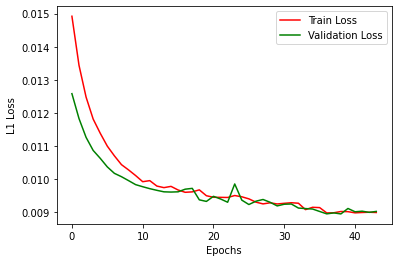

In [ ]:
plt.plot(history["train_loss"], c = "r", label = "Train Loss")
plt.plot(history["val_loss"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("L1 Loss")
plt.show()

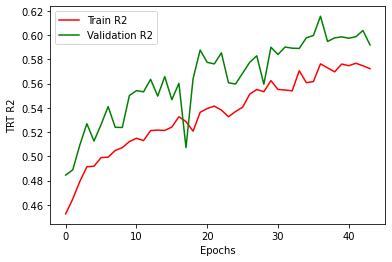

In [ ]:
plt.plot(history["train_TRT"], c = "r", label = "Train R2")
plt.plot(history["val_TRT"], c = "g", label = "Validation R2")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("TRT R2")
plt.show()

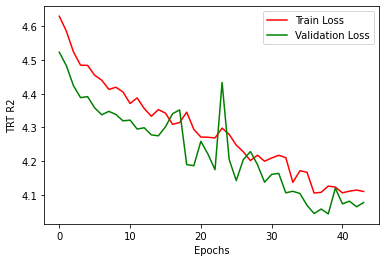

In [ ]:
plt.plot(history["train_TRT_mae"], c = "r", label = "Train Loss")
plt.plot(history["val_TRT_mae"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("TRT R2")
plt.show()

In [ ]:
display_data = [[best["train_TRT_mae"], best["val_TRT_mae"], best["test_TRT_mae"]], [best["train_TRT"], best["val_TRT"], best["test_TRT"]]]
display_df = pd.DataFrame(display_data, columns = ["Train", "Val", "Test"], index = ["MAE", "R2"])
display_df

,Train,Val,Test
MAE,4.125842,4.043161,8.951373
R2,0.569627,0.597627,-0.194432


In [ ]:
test_loss, test_r2, test_mae = eval_model(model, test_data_loader, loss_fn, device)
test_r2, test_mae

({'TRT': -0.19938280901126548}, {'TRT': 8.976665})

In [ ]:
save_file_path = "/content/drive/My Drive/CMCL Shared Task/single target training/Error Analysis/Model pth/MinMax_Single_SW_WL_NN_LL_EW_TDF_POS_RobTok_TRT.pth"
torch.save(model.state_dict(), save_file_path)